In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## Data overview

In [3]:
data = pd.read_csv('datasets/cab_historical_data.csv')

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
data.shape

(26496, 2)

##### Conclusões
* 26496 registros e 2 features
* Tipo de dados da feature 'datetime' precisa ser corrigido para tipo datetime

## Preprocessing

A seguir será corrigido o tipo de dado da feature datetime e além disso uma featura adicional 'hour' será adicionada para uma EDA mais acertiva.

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [8]:
data['hour'] = data.datetime.dt.hour

In [9]:
data.set_index('datetime', inplace=True)

In [10]:
data.sort_index(inplace=True)

In [11]:
data = data.resample('1H').sum()

In [12]:
weekly_data = data['2018-03-01':'2018-03-07']

## EDA

Será verificado qual o horário ou faixa de pico de chamados, a fim de compreender melhor o comportamento dos clientes e validar o desempenho do modelo.

A fim de extrair o máximo das séries temporais, serão extraídos os sinais de Tendência, Sazonalidade, e Resíduo, seno que o mais importante é a Sazonalidade, que indica um acontecimento repetido em um determinado intervalo.

#### Temporal series signals overview

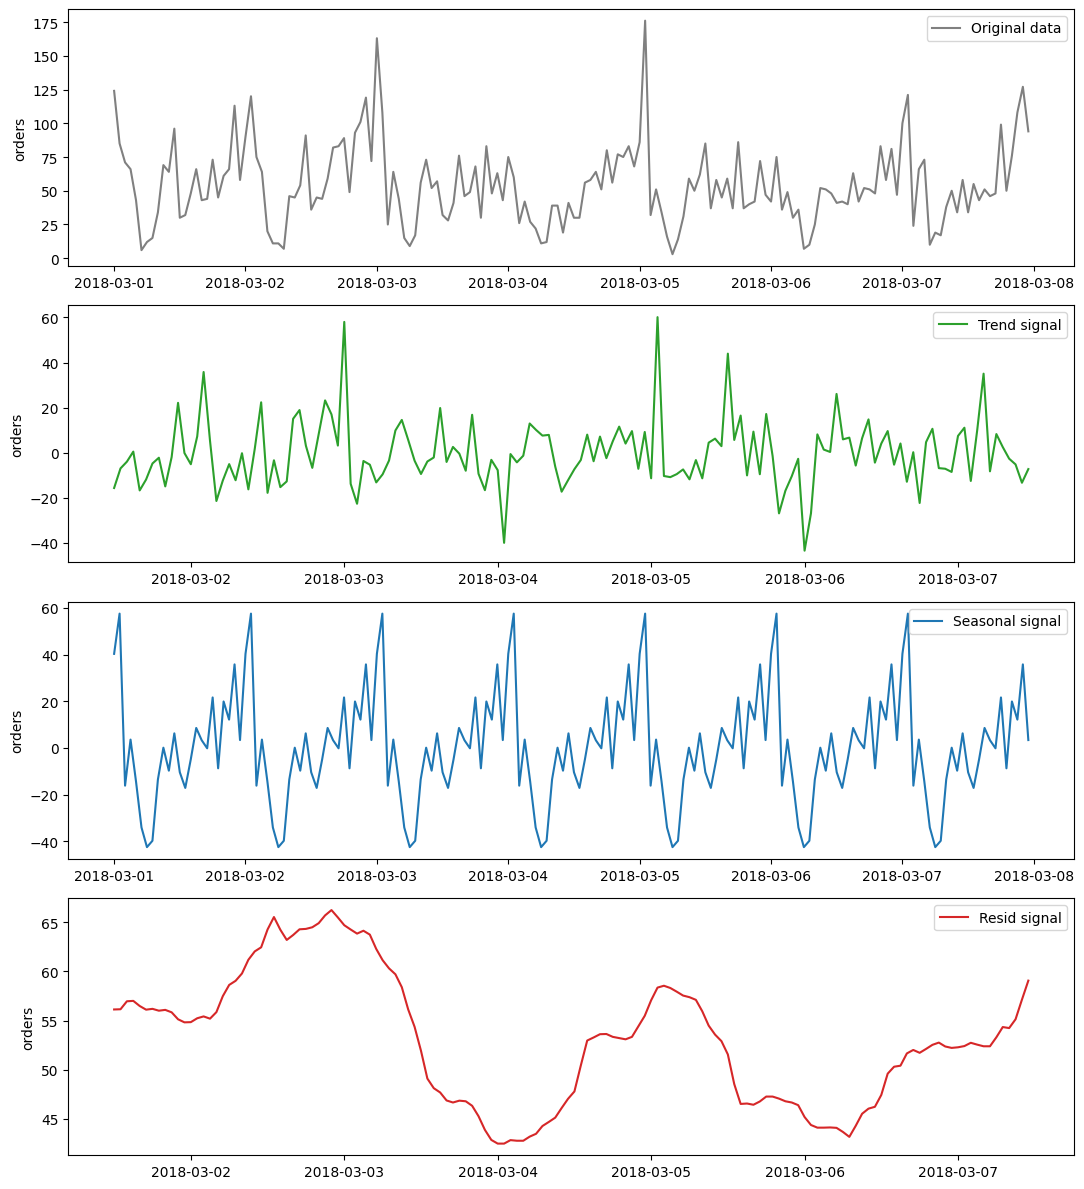

In [56]:
# Tseries signals decompose
decomposed = seasonal_decompose(weekly_data.drop(columns='hour'))
trend, season, resid = decomposed.resid, decomposed.seasonal, decomposed.trend

# Plot
plt.figure(figsize=(11, 12))

# Original data
plt.subplot(411)
plt.plot(weekly_data.drop(columns='hour'), label='Original data', color='gray')
plt.ylabel('orders')
plt.legend()

# Trend
plt.subplot(412)
plt.plot(trend, label='Trend signal', color='C2')
plt.ylabel('orders')
plt.legend()

# Season
plt.subplot(413)
plt.plot(season, label='Seasonal signal', )
plt.ylabel('orders')
plt.legend()

# Resid
plt.subplot(414)
plt.plot(resid, label='Resid signal', color='C3')
plt.ylabel('orders')
plt.legend()

plt.tight_layout()
plt.show()

##### Conclusões:
* O gráfico de Sazonalidade evidenciou a existência de horário de pico, que será explorada

#### Closer seasonal analysis

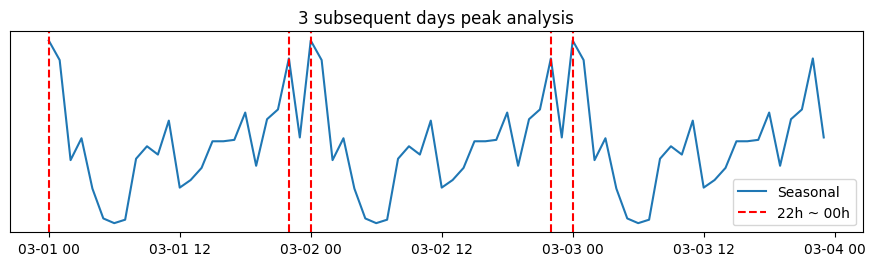

Median of orders - 22h~00h:
num_orders    55.0
dtype: float64


In [58]:
# 3-day range
data_3days = data['2018-03-01':'2018-03-03'].drop(columns='hour')

# Tseries decomposition
decomposed = seasonal_decompose(data_3days)
trend, season, resid = decomposed.resid, decomposed.seasonal, decomposed.trend

# Plot
plt.figure(figsize=(11, 12))

# Desired range (22h ~ 00h)
vert_data = ['2018-03-01 22:00:00','2018-03-02 00:00:00',
             '2018-03-02 22:00:00','2018-03-03 00:00:00', '2018-03-01 00:00:00']

vert_data = pd.to_datetime(vert_data)

# Seasonal plot
plt.subplot(411)
plt.plot(season, label='Seasonal',)
n = 0
for v_data in vert_data:
    plt.axvline(x=v_data, color='red', linestyle='--', label='' if n != 0 else '22h ~ 00h')
    n+=1
plt.yticks([])
plt.legend()
plt.title('3 subsequent days peak analysis')
plt.show()

print('Median of orders - 22h~00h:')
print(data_3days.median())

##### Conclusões:
*
*

## Modeling

## Final test

## Final conclusions
Os dados foram avaliados e filtrados e percebeu-se uma forte sasonalidade, ou seja padrões que se repetem com o tempo bastante evidentes foram encontrados.
Foi identificado durante a análise que a faixa das 22~00h é uma faixa em que ocorre um pico na demanda de pedidos, acima de 90 chamados. Dentre os modelos testados o que se destacou por conta de seu baixo erro foi o LGBMRegressor, com (RMSE ≅ 46) no conjunto de testes, bem abaixo do proposto (RMSE ≤ 48) sendo portanto a melhor alternativa.

* Melhor modelo: random forest
* Faixa de pico: das 22h as 00h
* Demanda de pico: 90+ chamados